# Multilayer Perceptron (MLP)

In [ ]:
# reset variables
%reset -f

In [ ]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from tabulate import tabulate

import keras
from keras import layers, regularizers, Input, Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import functions as f
import dl_functions as dlf
from generators import batch_generator

In [3]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Read and load data

In [4]:
df_train, df_valid, df_test = f.load_data()
#df_train, df_valid, df_test = f.load_data(dummy_data=True, dummy_obs=5000)
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values

## Model evaluation function

In [5]:
def evaluate_errors(errors, stds = stats.loc[target_tags, "Std"].values):
    
    maes = pd.DataFrame(errors, columns=["FT", "TT", "PT"]).mean().values
    maes_unstd = maes * stds
    
    indexes = ["FT", "TT", "PT"]
    cols = ["MAE (std)", "MAE (unstd)"]
    data = np.column_stack([maes, maes_unstd])
    err_df = pd.DataFrame(data, index=indexes, columns=cols)
    err_df.loc["Avg"] = err_df.mean()

    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'df': err_df,
        'str_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
    }
    
    return return_dict

In [6]:
def evaluate_mlp(model_func, train_tuple, valid_tuple, test_tuple, name, 
                 epochs=30, iterations=5, batch_size=128, make_plots=True):
    
    root_path = os.path.abspath(".").split("src")[0]
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
        
    models = []
    histories = []
    val_losses = []
    test_losses = []
    
    for i in range(iterations):
        model = model_func(train_tuple[0].shape[-1], train_tuple[1].shape[-1])
        
        print("Training model {0} #{1}".format(name, i+1))
        weights_checkpoint = model_folder + "weights_{0}.h5".format(i+1)
        
        callbacks = [
            ModelCheckpoint(
                filepath=weights_checkpoint, monitor='val_loss',verbose=1,
                save_weights_only=True,save_best_only=True
            ),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.25, patience = 5, verbose = 1, min_lr=1e-5,
            )
        ]
    
        model.compile(loss='mae', optimizer=Adam())
        history = model.fit(train_tuple[0], train_tuple[1],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_tuple,
                            callbacks=callbacks)

        if make_plots: dlf.plot_history(history)

        # load the weights at the best checkpoint
        model.load_weights(weights_checkpoint)
    
        # Performance on validation data
        preds = model.predict(valid_tuple[0])
        true = valid_tuple[1]
        val_maes = f.MAE(true,preds,vector=True)

        # Performance on testing data
        preds = model.predict(test_tuple[0])
        true = test_tuple[1]
        test_maes = f.MAE(true, preds,vector=True)
        
        models.append(model)
        histories.append(history)
        val_losses.append(val_maes)
        test_losses.append(test_maes)
    
    val_avg_mae = np.average([np.average(errs) for errs in val_losses])
    test_avg_mae = np.average([np.average(errs) for errs in test_losses])
    
    val_dict = evaluate_errors(val_losses)
    test_dict = evaluate_errors(test_losses)
    
    print("\n**** Validation ****")
    print("Averaged over {0} iterations".format(iterations))
    print(val_dict['str_table'])
    
    print("\n**** Testing ****")
    print("Averaged over {0} iterations".format(iterations))
    print(test_dict['str_table'])
    
    return_dict = {
        'val_losses': val_losses,
        'test_losses': test_losses,
        'validation': val_dict,
        'test': test_dict,
        'histories': histories,
        'models': models
    }
    
    # save dictionary to model folder
    f.save_pickle(obj=return_dict, fpath=model_folder+"model_dict.pkl")
    
    return return_dict

# MLP with 128 hidden nodes

In [7]:
def mlp_128(num_inputs, num_outputs):
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(num_inputs,)))
    model.add(Dropout(0.3))
    model.add(Dense(num_outputs))
              
    return model

Training model mlp_128 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.5423 - val_loss: 0.5106

Epoch 00001: val_loss improved from inf to 0.51064, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4873 - val_loss: 0.4992

Epoch 00002: val_loss improved from 0.51064 to 0.49919, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 3/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4786 - val_loss: 0.4969

Epoch 00003: val_loss improved from 0.49919 to 0.49694, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 4/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4745 - val_loss: 0.4952

Epoch 00004: val_loss improved from 0.49694 to 0.49523, saving model to /home/shomeb/

53210/53210 [==============================] - 0s 4us/step - loss: 0.4628 - val_loss: 0.4888

Epoch 00045: val_loss did not improve from 0.48738
Epoch 46/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4625 - val_loss: 0.4885

Epoch 00046: val_loss did not improve from 0.48738
Epoch 47/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4629 - val_loss: 0.4882

Epoch 00047: val_loss did not improve from 0.48738

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 48/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4629 - val_loss: 0.4887

Epoch 00048: val_loss did not improve from 0.48738
Epoch 49/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4625 - val_loss: 0.4888

Epoch 00049: val_loss did not improve from 0.48738
Epoch 50/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4629 - val_loss: 0.4887

Epoch 00050: val_loss did not improve f

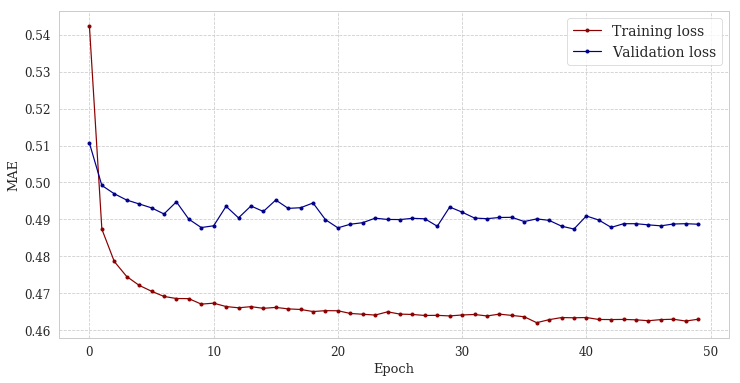

Training model mlp_128 #2
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.5400 - val_loss: 0.5120

Epoch 00001: val_loss improved from inf to 0.51196, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 2/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4854 - val_loss: 0.4959

Epoch 00002: val_loss improved from 0.51196 to 0.49592, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 3/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4769 - val_loss: 0.4917

Epoch 00003: val_loss improved from 0.49592 to 0.49171, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 4/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4733 - val_loss: 0.4956

Epoch 00004: val_loss did not improve from 0.49171
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 4us/step - loss: 0.4621 - val_loss: 0.4871

Epoch 00048: val_loss did not improve from 0.48406
Epoch 49/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4627 - val_loss: 0.4874

Epoch 00049: val_loss did not improve from 0.48406
Epoch 50/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4626 - val_loss: 0.4872

Epoch 00050: val_loss did not improve from 0.48406


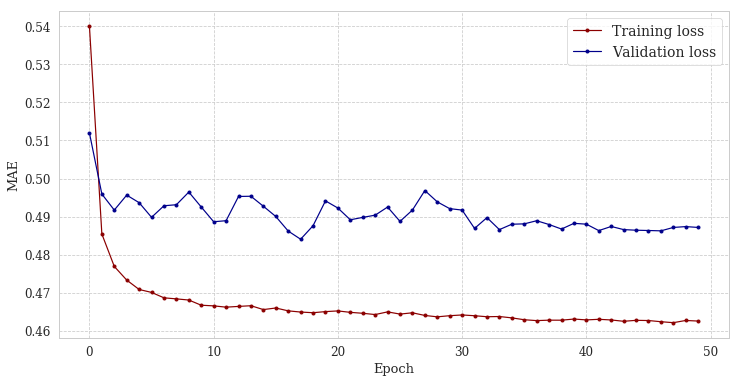

Training model mlp_128 #3
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.5377 - val_loss: 0.5085

Epoch 00001: val_loss improved from inf to 0.50851, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 2/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4860 - val_loss: 0.5030

Epoch 00002: val_loss improved from 0.50851 to 0.50302, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 3/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4774 - val_loss: 0.4982

Epoch 00003: val_loss improved from 0.50302 to 0.49817, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 4/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4739 - val_loss: 0.4942

Epoch 00004: val_loss improved from 0.49817 to 0.49417, saving model to /home/shomeb/

53210/53210 [==============================] - 0s 5us/step - loss: 0.4635 - val_loss: 0.4866

Epoch 00045: val_loss did not improve from 0.48127
Epoch 46/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4624 - val_loss: 0.4868

Epoch 00046: val_loss did not improve from 0.48127
Epoch 47/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4625 - val_loss: 0.4872

Epoch 00047: val_loss did not improve from 0.48127
Epoch 48/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4627 - val_loss: 0.4865

Epoch 00048: val_loss did not improve from 0.48127
Epoch 49/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4623 - val_loss: 0.4875

Epoch 00049: val_loss did not improve from 0.48127

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 50/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4623 - val_loss: 0.4872

Epoch 00050: val_loss did not improve f

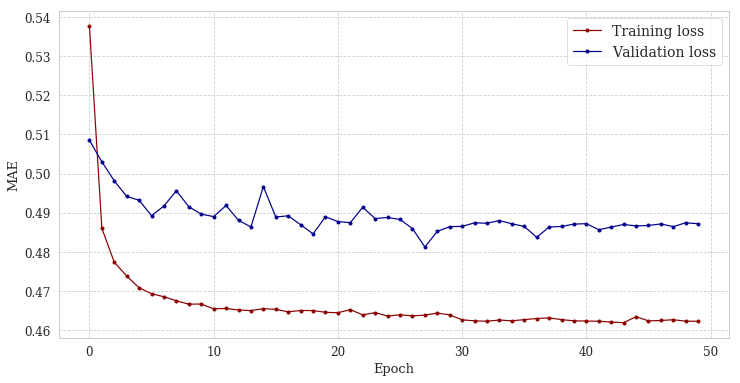

Training model mlp_128 #4
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.5441 - val_loss: 0.5127

Epoch 00001: val_loss improved from inf to 0.51270, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 2/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4885 - val_loss: 0.4991

Epoch 00002: val_loss improved from 0.51270 to 0.49909, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 3/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4794 - val_loss: 0.4930

Epoch 00003: val_loss improved from 0.49909 to 0.49301, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 4/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4743 - val_loss: 0.4935

Epoch 00004: val_loss did not improve from 0.49301
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 4us/step - loss: 0.4624 - val_loss: 0.4867

Epoch 00048: val_loss did not improve from 0.48353

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4625 - val_loss: 0.4868

Epoch 00049: val_loss did not improve from 0.48353
Epoch 50/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4623 - val_loss: 0.4870

Epoch 00050: val_loss did not improve from 0.48353


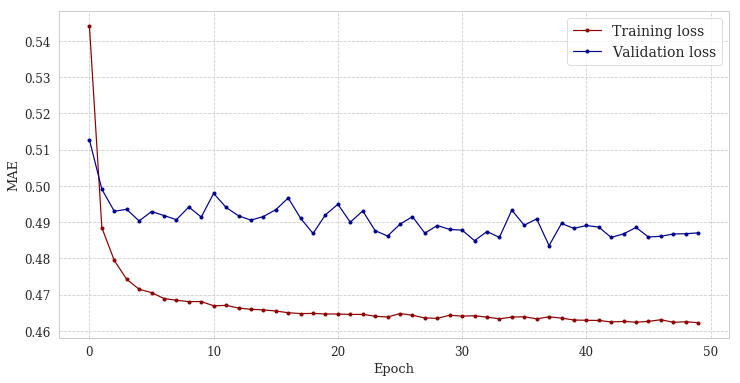

Training model mlp_128 #5
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.5367 - val_loss: 0.5067

Epoch 00001: val_loss improved from inf to 0.50671, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 2/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4872 - val_loss: 0.4995

Epoch 00002: val_loss improved from 0.50671 to 0.49952, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 3/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4782 - val_loss: 0.4939

Epoch 00003: val_loss improved from 0.49952 to 0.49390, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 4/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4741 - val_loss: 0.4929

Epoch 00004: val_loss improved from 0.49390 to 0.49294, saving model to /home/shomeb/


Epoch 00046: val_loss did not improve from 0.48256
Epoch 47/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4622 - val_loss: 0.4872

Epoch 00047: val_loss did not improve from 0.48256
Epoch 48/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4627 - val_loss: 0.4877

Epoch 00048: val_loss did not improve from 0.48256

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4619 - val_loss: 0.4876

Epoch 00049: val_loss did not improve from 0.48256
Epoch 50/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.4622 - val_loss: 0.4876

Epoch 00050: val_loss did not improve from 0.48256


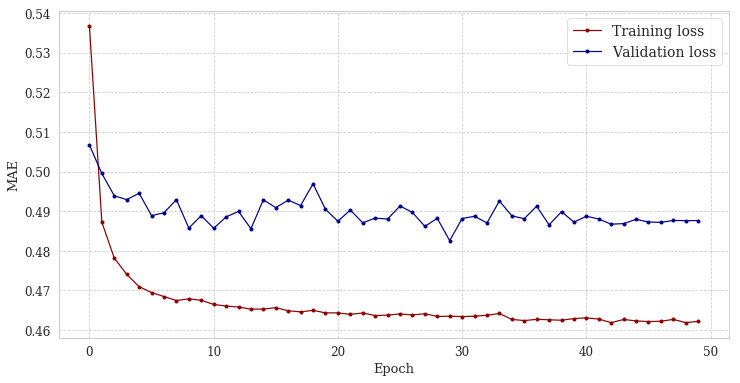


**** Validation ****
Averaged over 5 iterations
+-----+-------------+---------------+
|     |   MAE (std) |   MAE (unstd) |
|-----+-------------+---------------|
| FT  |     0.65370 |    2207.31843 |
| TT  |     0.29228 |       0.28542 |
| PT  |     0.50530 |       0.12506 |
| Avg |     0.48376 |     735.90964 |
+-----+-------------+---------------+

**** Testing ****
Averaged over 5 iterations
+-----+-------------+---------------+
|     |   MAE (std) |   MAE (unstd) |
|-----+-------------+---------------|
| FT  |     0.59040 |    1993.57828 |
| TT  |     0.23496 |       0.22945 |
| PT  |     0.49396 |       0.12225 |
| Avg |     0.43977 |     664.64333 |
+-----+-------------+---------------+


In [8]:
K.clear_session()

batch_size=256
epochs=50
iterations=5
name = "mlp_128"

mlp_128_dict = evaluate_mlp(mlp_128, 
                            train_tuple=(x_train, y_train), 
                            valid_tuple=(x_valid, y_valid), 
                            test_tuple=(x_test, y_test), 
                            name=name, 
                            epochs=epochs,
                            iterations=iterations,
                            batch_size=batch_size)

## MLP with 512 hidden nodes

In [9]:
def mlp_512(num_inputs, num_outputs):
    
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_inputs,), kernel_initializer = 'glorot_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(num_outputs))
              
    return model

Training model mlp_512 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 11us/step - loss: 0.5010 - val_loss: 0.5048

Epoch 00001: val_loss improved from inf to 0.50482, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4666 - val_loss: 0.4935

Epoch 00002: val_loss improved from 0.50482 to 0.49355, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 3/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4613 - val_loss: 0.4894

Epoch 00003: val_loss improved from 0.49355 to 0.48936, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 4/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4588 - val_loss: 0.4954

Epoch 00004: val_loss did not improve from 0.48936
Epoch 5/50
53210/53210 [=========

53210/53210 [==============================] - 0s 8us/step - loss: 0.4460 - val_loss: 0.4813

Epoch 00048: val_loss did not improve from 0.48125
Epoch 49/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4467 - val_loss: 0.4852

Epoch 00049: val_loss did not improve from 0.48125
Epoch 50/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4467 - val_loss: 0.4850

Epoch 00050: val_loss did not improve from 0.48125


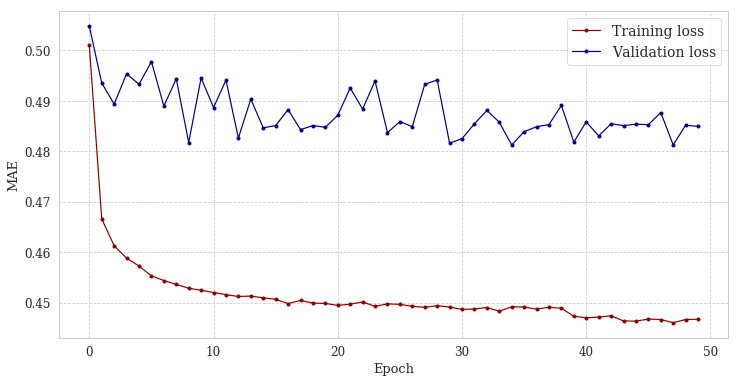

Training model mlp_512 #2
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 11us/step - loss: 0.5032 - val_loss: 0.5014

Epoch 00001: val_loss improved from inf to 0.50136, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 2/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4667 - val_loss: 0.4941

Epoch 00002: val_loss improved from 0.50136 to 0.49409, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 3/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4609 - val_loss: 0.4922

Epoch 00003: val_loss improved from 0.49409 to 0.49222, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 4/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4586 - val_loss: 0.4961

Epoch 00004: val_loss did not improve from 0.49222
Epoch 5/50
53210/53210 [=========

53210/53210 [==============================] - 0s 9us/step - loss: 0.4466 - val_loss: 0.4839

Epoch 00046: val_loss did not improve from 0.48105
Epoch 47/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4463 - val_loss: 0.4835

Epoch 00047: val_loss did not improve from 0.48105
Epoch 48/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4464 - val_loss: 0.4834

Epoch 00048: val_loss did not improve from 0.48105
Epoch 49/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4459 - val_loss: 0.4832

Epoch 00049: val_loss did not improve from 0.48105

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 50/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4459 - val_loss: 0.4832

Epoch 00050: val_loss did not improve from 0.48105


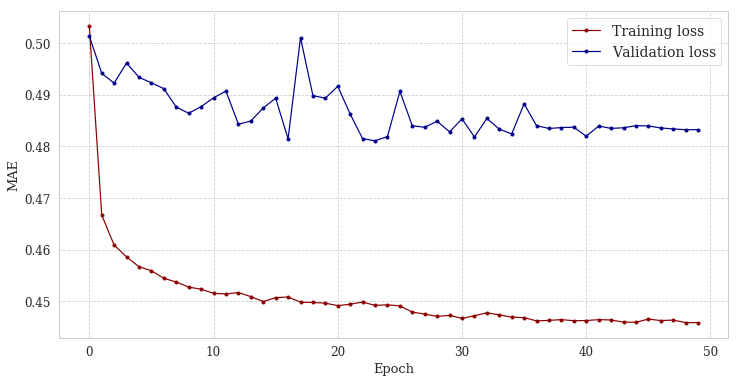

Training model mlp_512 #3
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 12us/step - loss: 0.4948 - val_loss: 0.5018

Epoch 00001: val_loss improved from inf to 0.50179, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 2/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4650 - val_loss: 0.5007

Epoch 00002: val_loss improved from 0.50179 to 0.50067, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 3/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4605 - val_loss: 0.4922

Epoch 00003: val_loss improved from 0.50067 to 0.49224, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 4/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4583 - val_loss: 0.4937

Epoch 00004: val_loss did not improve from 0.49224
Epoch 5/50
53210/53210 [=========

53210/53210 [==============================] - 0s 9us/step - loss: 0.4470 - val_loss: 0.4847

Epoch 00048: val_loss did not improve from 0.47870
Epoch 49/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4468 - val_loss: 0.4831

Epoch 00049: val_loss did not improve from 0.47870
Epoch 50/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4470 - val_loss: 0.4833

Epoch 00050: val_loss did not improve from 0.47870


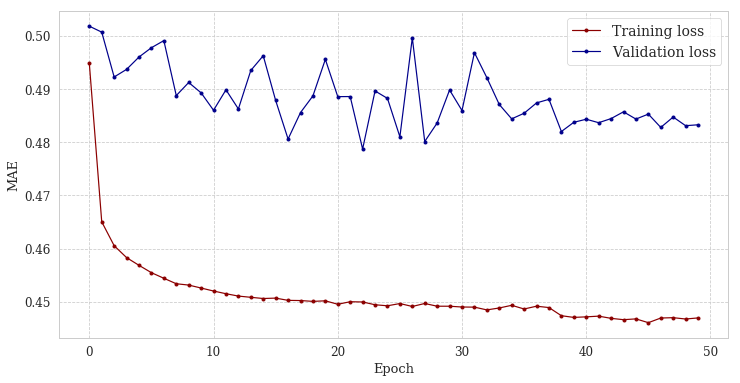

Training model mlp_512 #4
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 12us/step - loss: 0.4987 - val_loss: 0.4973

Epoch 00001: val_loss improved from inf to 0.49729, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_4.h5
Epoch 2/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4658 - val_loss: 0.4958

Epoch 00002: val_loss improved from 0.49729 to 0.49580, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_4.h5
Epoch 3/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4614 - val_loss: 0.5044

Epoch 00003: val_loss did not improve from 0.49580
Epoch 4/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4586 - val_loss: 0.5016

Epoch 00004: val_loss did not improve from 0.49580
Epoch 5/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4566 - val_loss: 0.4944

Epoch 00005: val_l

53210/53210 [==============================] - 0s 9us/step - loss: 0.4467 - val_loss: 0.4840

Epoch 00046: val_loss did not improve from 0.47934
Epoch 47/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4464 - val_loss: 0.4828

Epoch 00047: val_loss did not improve from 0.47934
Epoch 48/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4468 - val_loss: 0.4836

Epoch 00048: val_loss did not improve from 0.47934

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4463 - val_loss: 0.4831

Epoch 00049: val_loss did not improve from 0.47934
Epoch 50/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4463 - val_loss: 0.4836

Epoch 00050: val_loss did not improve from 0.47934


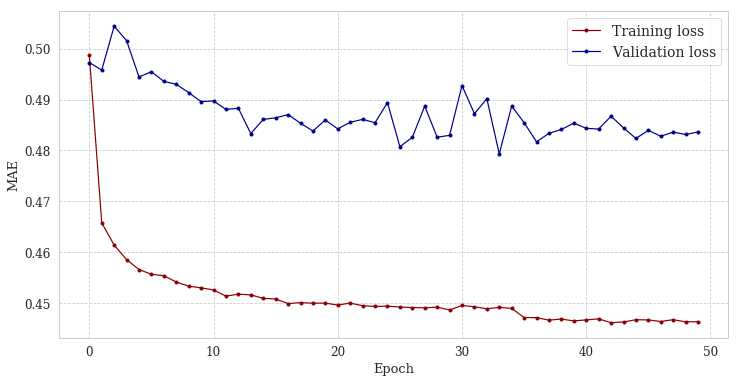

Training model mlp_512 #5
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 10us/step - loss: 0.4992 - val_loss: 0.5111

Epoch 00001: val_loss improved from inf to 0.51115, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 2/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4668 - val_loss: 0.4951

Epoch 00002: val_loss improved from 0.51115 to 0.49506, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 3/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4617 - val_loss: 0.4902

Epoch 00003: val_loss improved from 0.49506 to 0.49024, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 4/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4587 - val_loss: 0.4994

Epoch 00004: val_loss did not improve from 0.49024
Epoch 5/50
53210/53210 [=========


Epoch 00047: val_loss did not improve from 0.48126
Epoch 48/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4468 - val_loss: 0.4852

Epoch 00048: val_loss did not improve from 0.48126

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4460 - val_loss: 0.4846

Epoch 00049: val_loss did not improve from 0.48126
Epoch 50/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4463 - val_loss: 0.4853

Epoch 00050: val_loss did not improve from 0.48126


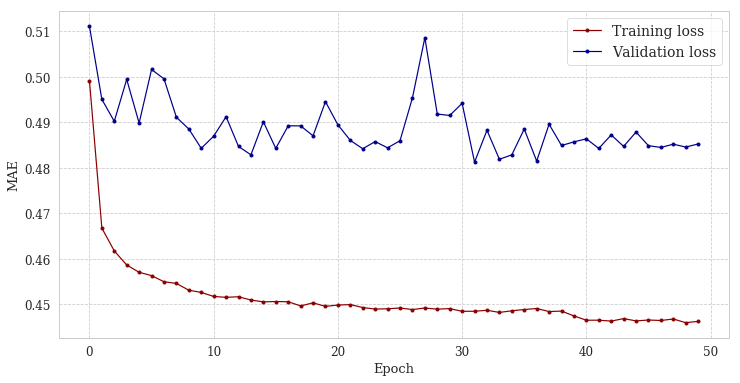


**** Validation ****
Averaged over 5 iterations
+-----+-------------+---------------+
|     |   MAE (std) |   MAE (unstd) |
|-----+-------------+---------------|
| FT  |     0.64536 |    2179.16420 |
| TT  |     0.29516 |       0.28823 |
| PT  |     0.50044 |       0.12385 |
| Avg |     0.48032 |     726.52543 |
+-----+-------------+---------------+

**** Testing ****
Averaged over 5 iterations
+-----+-------------+---------------+
|     |   MAE (std) |   MAE (unstd) |
|-----+-------------+---------------|
| FT  |     0.57948 |    1956.73245 |
| TT  |     0.23456 |       0.22905 |
| PT  |     0.48811 |       0.12080 |
| Avg |     0.43405 |     652.36077 |
+-----+-------------+---------------+


In [10]:
K.clear_session()

batch_size=256
epochs=50
iterations=5
name = "mlp_512"

mlp_512_dict = evaluate_mlp(mlp_512, 
                            train_tuple=(x_train, y_train), 
                            valid_tuple=(x_valid, y_valid), 
                            test_tuple=(x_test, y_test), 
                            name=name, 
                            epochs=epochs,
                            iterations=iterations,
                            batch_size=batch_size)

# Summary and exporting results

In [11]:
dicts = [mlp_128_dict, mlp_512_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["MLP 128", "MLP 512"]
mlp_summary, tex = dlf.get_df_from_dicts(dicts, columns, index)

print(tex)
mlp_summary

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{MLP 128} &     0.6537 &  0.2923 &  0.5053 &  0.4838 &  0.5904 &  0.2350 &  0.4940 &  0.4398 \\
\textbf{MLP 512} &     0.6454 &  0.2952 &  0.5004 &  0.4803 &  0.5795 &  0.2346 &  0.4881 &  0.4341 \\
\bottomrule
\end{tabular}



Validation                            Test                        
                FT      TT      PT     Avg      FT      TT      PT     Avg
MLP 128     0.6537  0.2923  0.5053  0.4838  0.5904  0.2350  0.4940  0.4398
MLP 512     0.6454  0.2952  0.5004  0.4803  0.5795  0.2346  0.4881  0.4341

In [12]:
path = ROOT_PATH + "models/dataframes/"

mlp_summary.to_pickle(path + "mlp_summary_df.pkl")